# 1. Importing libraries

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings


warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

# 2. Test run with coinmarketCap api

In [5]:
from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json

url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest' 
parameters = {
  'start':'1',
  'limit':'5000',
  'convert':'USD'
}
headers = {
  'Accepts': 'application/json',
  'X-CMC_PRO_API_KEY': '97bbc70b6a0642359ccd2c01059ee617',
}

session = Session()
session.headers.update(headers)

try:
  response = session.get(url, params=parameters)
  data = json.loads(response.text)
  print(data)
except (ConnectionError, Timeout, TooManyRedirects) as e:
  print(e)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Test failed due to subscription limitation

### Make another test fetch with cmc api

In [29]:
from requests import Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects

API_KEY = "97bbc70b6a0642359ccd2c01059ee617"  

url = "https://pro-api.coinmarketcap.com/v1/cryptocurrency/quotes/latest"
params = {"symbol": "BTC", "convert": "USD"}
headers = {"Accepts": "application/json", "X-CMC_PRO_API_KEY": API_KEY}

session = Session(); session.headers.update(headers)

try:
    r = session.get(url, params=params, timeout=15)
    r.raise_for_status()
    data = r.json()
    price = data["data"]["BTC"]["quote"]["USD"]["price"]
    print(f"BTC price (USD): {price:.2f}")
except (ConnectionError, Timeout, TooManyRedirects) as e:
    print("Network error:", e)
except Exception as e:
    print("Unexpected error:", e)


BTC price (USD): 113774.45


# 3. fetch data with cmc api again

In [ ]:
# --- Setup ---
import os, datetime as dt, requests
import pandas as pd
import matplotlib.pyplot as plt

API_KEY = os.getenv("CMC_API_KEY", "97bbc70b6a0642359ccd2c01059ee617")  # <-- prefer env var

BASE = "https://pro-api.coinmarketcap.com"
ENDPOINT = "/v2/cryptocurrency/ohlcv/historical"

# last 10 years from today
time_end = dt.datetime.utcnow().date()
time_start = time_end.replace(year=time_end.year - 10)

params = {
    "symbol": "BTC",
    "convert": "USD",
    "time_start": time_start.isoformat(),  # e.g., '2015-10-21'
    "time_end": time_end.isoformat(),      # e.g., '2025-10-21'
    "interval": "daily"
}

headers = {"Accepts": "application/json", "X-CMC_PRO_API_KEY": API_KEY}

# --- Request ---
r = requests.get(BASE + ENDPOINT, params=params, headers=headers, timeout=30)
r.raise_for_status()
payload = r.json()

# --- Parse ---
# Expected structure (v2):
# payload["data"]["BTC"]["quotes"] -> list of { "time_open", "time_close", "quote": { "USD": {..., "close": ...} } }
quotes = payload["data"]["BTC"]["quotes"]

df = pd.DataFrame({
    "date": pd.to_datetime([q["time_close"] for q in quotes]),
    "close_usd": [q["quote"]["USD"]["close"] for q in quotes],
})
df = df.sort_values("date").reset_index(drop=True)

# --- Plot ---
plt.figure(figsize=(10, 5))
plt.plot(df["date"], df["close_usd"])
plt.title("Bitcoin (BTC) — Closing Price, Last 10 Years")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.tight_layout()
plt.show()

Doesn't work because API key needs plan upgrade. Changing to Coingecko API.

Free API Key only allows for 365 days of price data.

# 4. Change to coingecko api

### plot btc time series chart

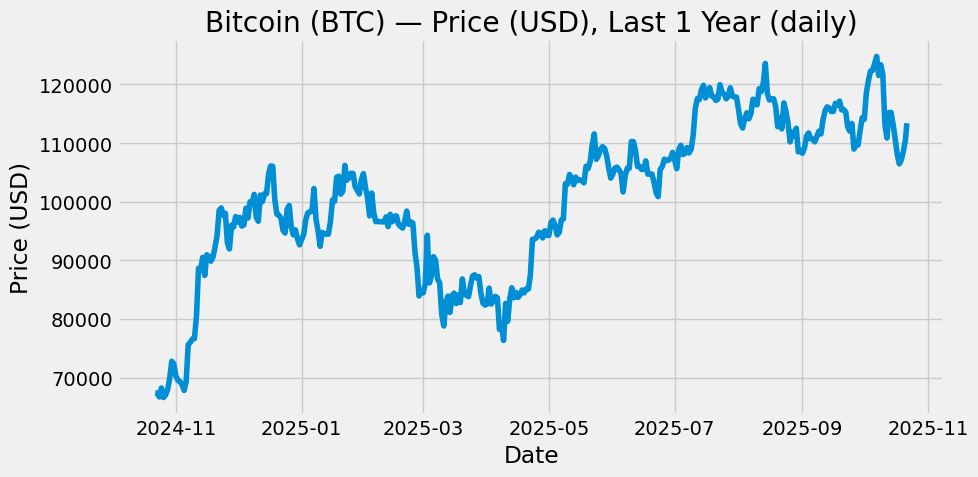

Saved chart to: /Users/davidscheider/anaconda_projects/Bitcoin Analytics/btc_1y.png
Saved data  to: /Users/davidscheider/anaconda_projects/Bitcoin Analytics/btc_1y.csv
Data points: 366


In [21]:
import os, requests, pandas as pd, matplotlib.pyplot as plt

# --- Config ---
BASE = "https://api.coingecko.com/api/v3"
COIN = "bitcoin"
VS   = "usd"
DAYS = 365  # 1 year

headers = {"x-cg-api-key": "CG-raFWr2ngRvBfnYB8A5UCgX5m"}
params  = {"vs_currency": VS, "days": str(DAYS), "interval": "daily"}  # interval hint

url = f"{BASE}/coins/{COIN}/market_chart"
resp = requests.get(url, headers=headers, params=params, timeout=60)

if resp.status_code != 200:
    raise SystemExit(f"HTTP {resp.status_code}: {resp.text}")

data = resp.json()
prices = data["prices"]  # [[ms_since_epoch, price], ...]

df = pd.DataFrame(prices, columns=["ms", "close_usd"])
df["date"] = pd.to_datetime(df["ms"], unit="ms")
df = df[["date", "close_usd"]].sort_values("date")

plt.figure(figsize=(10,5))
plt.plot(df["date"], df["close_usd"])
plt.title("Bitcoin (BTC) — Price (USD), Last 1 Year (daily)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.tight_layout()

# --- Save files to folder ---
save_dir = "/Users/davidscheider/anaconda_projects/Bitcoin Analytics"
os.makedirs(save_dir, exist_ok=True)

png_path = os.path.join(save_dir, "btc_1y.png")
csv_path = os.path.join(save_dir, "btc_1y.csv")

plt.savefig(png_path, dpi=150, bbox_inches="tight")
plt.show()

df.to_csv(csv_path, index=False)

print(f"Saved chart to: {png_path}")
print(f"Saved data  to: {csv_path}")
print(f"Data points: {len(df)}")


# 5. Decompose chart

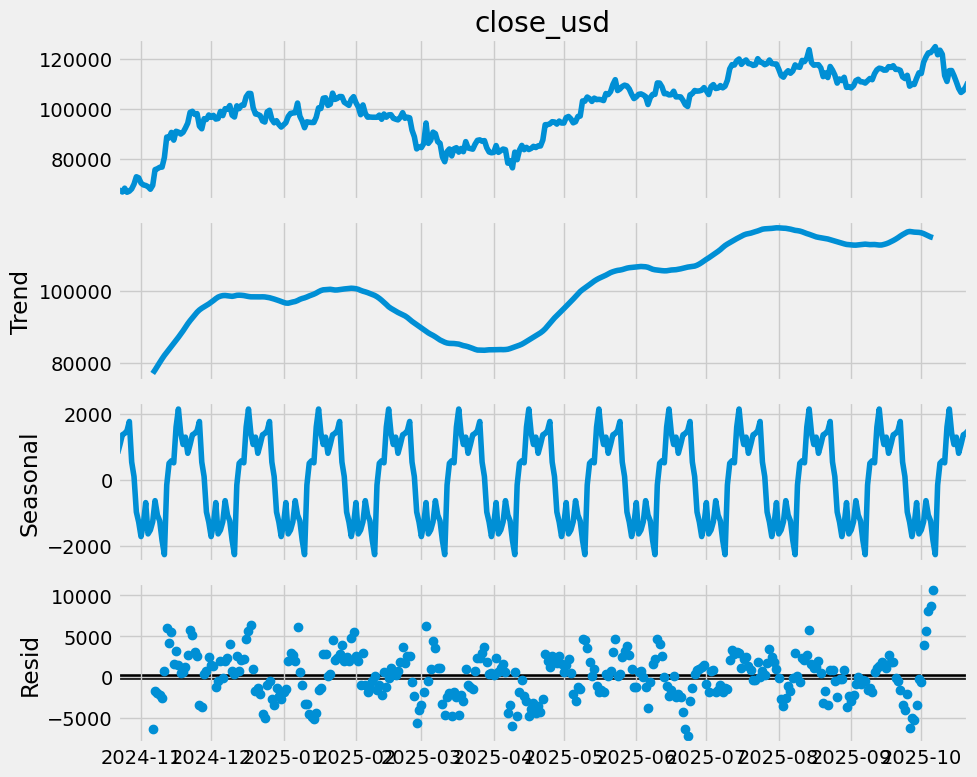

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Load saved BTC data (or use df from previous cell)
df = pd.read_csv("/Users/davidscheider/anaconda_projects/Bitcoin Analytics/btc_1y.csv", parse_dates=["date"])
df = df.set_index("date")
df = df.asfreq("D")  # ensure daily frequency

# Perform seasonal decomposition
decomposition = seasonal_decompose(df["close_usd"], model="additive", period=30)  # roughly monthly seasonality

# Plot the components
fig = decomposition.plot()
fig.set_size_inches(10, 8)
plt.tight_layout()

# save decomposition plot
plt.savefig("/Users/davidscheider/anaconda_projects/Bitcoin Analytics/btc_1y_decomposition.png", dpi=150, bbox_inches="tight")
plt.show()


# 6. Perform Dickey-Fuller test

In [25]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

# Run the Augmented Dickey-Fuller test on the closing prices
result = adfuller(df["close_usd"].dropna())

# Display results
labels = ["ADF Statistic", "p-value", "# Lags Used", "# Observations Used"]
for label, value in zip(labels, result[:4]):
    print(f"{label}: {value}")

for key, val in result[4].items():
    print(f"Critical Value ({key}): {val}")

if result[1] < 0.05:
    print("\nResult: Reject the null hypothesis — the series is stationary.")
else:
    print("\nResult: Fail to reject the null hypothesis — the series is non-stationary.")


ADF Statistic: -2.495230852796775
p-value: 0.11663902624674188
# Lags Used: 0
# Observations Used: 364
Critical Value (1%): -3.4484434475193777
Critical Value (5%): -2.869513170510808
Critical Value (10%): -2.571017574266393

Result: Fail to reject the null hypothesis — the series is non-stationary.


# 7. conduct a round of differencing 

In [26]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

# First-order differencing
df["diff_close"] = df["close_usd"].diff()

# Drop missing value created by differencing
df_diff = df["diff_close"].dropna()

# Re-run the Augmented Dickey-Fuller test
result_diff = adfuller(df_diff)

# Display results
labels = ["ADF Statistic", "p-value", "# Lags Used", "# Observations Used"]
for label, value in zip(labels, result_diff[:4]):
    print(f"{label}: {value}")

for key, val in result_diff[4].items():
    print(f"Critical Value ({key}): {val}")

if result_diff[1] < 0.05:
    print("\nResult: Reject the null hypothesis — the differenced series is stationary.")
else:
    print("\nResult: Fail to reject the null hypothesis — the differenced series is still non-stationary.")


ADF Statistic: -19.772536636360595
p-value: 0.0
# Lags Used: 0
# Observations Used: 363
Critical Value (1%): -3.448493650810824
Critical Value (5%): -2.8695352280356556
Critical Value (10%): -2.5710293341377715

Result: Reject the null hypothesis — the differenced series is stationary.


# 8. Check for autocorrelation

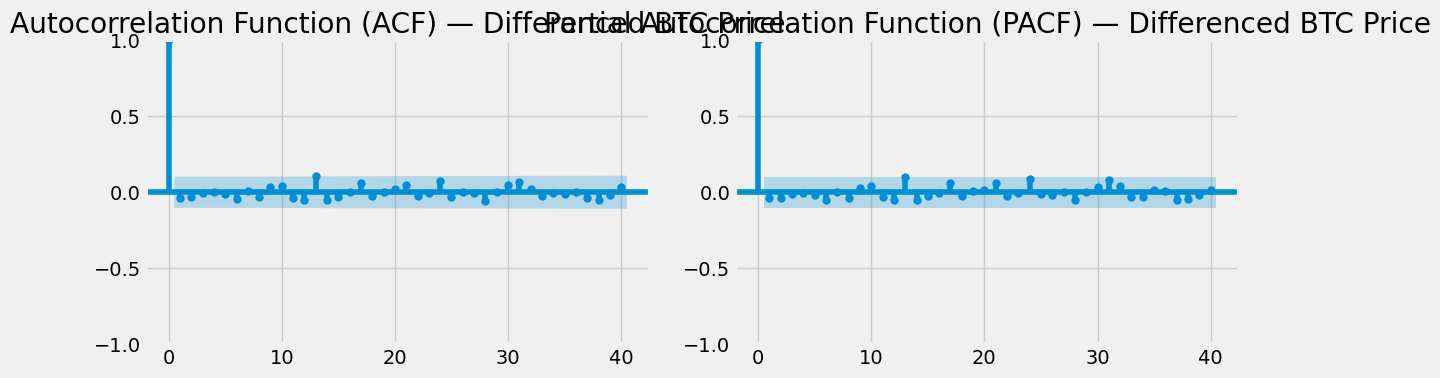

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(df["diff_close"].dropna(), ax=axes[0], lags=40)
axes[0].set_title("Autocorrelation Function (ACF) — Differenced BTC Price")

plot_pacf(df["diff_close"].dropna(), ax=axes[1], lags=40, method="ywm")
axes[1].set_title("Partial Autocorrelation Function (PACF) — Differenced BTC Price")

plt.tight_layout()
plt.savefig("/Users/davidscheider/anaconda_projects/Bitcoin Analytics/btc_1y_acf_pacf.png", dpi=150, bbox_inches="tight")
plt.show()
